In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
from sympy import S, symbols, printing
import sys

from openfermion.config import *
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.chem import geometry_from_pubchem
from openfermion.hamiltonians import jellium_model
from openfermion.utils import Grid, count_qubits
from openfermion.transforms import jordan_wigner, fourier_transform, get_fermion_operator
from openfermion.linalg import eigenspectrum, qubit_operator_sparse, get_sparse_operator
from openfermion.ops import QubitOperator
from openfermion.ops import general_basis_change

#from shapely.geometry import LineString

import os
import json
import pickle


In [2]:
#A function to help convert from the default output of openfermion to the style we require to run our simulator, 
# a numpy array that is structured as a list of hamiltonian terms. 
from sympy import EX


def openfermion_matrix_list(qubit_operator):
    qubit_operator.compress()
    total_qubits = count_qubits(qubit_operator)
    matrix_list = []
    op_list = list(qubit_operator)
    for i in op_list:
        matrix_list.append(get_sparse_operator(i, total_qubits).toarray()) #changed from qubit operator and made no differnce
    return np.array(matrix_list)

    #Test -- shows ops are equivalent
def test_list_generator(openfermion_output):
    max_val = []
    of_generator = get_sparse_operator(openfermion_output).toarray()
    list_generator = sum(openfermion_matrix_list(openfermion_output))
    the_zero_op = of_generator - list_generator
    for i in range(the_zero_op.shape[0]):
        for j in range(the_zero_op.shape[0]):
            max_val.append((the_zero_op)[i][j])
    print(max(max_val))
    norm = np.linalg.norm(the_zero_op, ord=2)
    if norm < 10**(-11):
        print("success!")
    else:
        print("failed!")
    return 0

def ham_spec(hamiltonian_list):
    norms = []
    index = []
    zero_norms = 0
    for i in range(len(hamiltonian_list)):
        h = hamiltonian_list[i]
        spec = np.linalg.norm(h, ord=2)
        norms.append(spec)
        index.append(i)
        if spec == 0:
            zero_norms += 1
    norms.sort()
    plt.figure(0)
    plt.plot(index, norms, 'o-')
    plt.xlabel("Index")
    plt.ylabel("Spectral Norm")
    plt.show()
    print("There are " + str(zero_norms) + " terms with 0 spectral norm")
    return norms

# def crossover_advantage(qd_data, trot_data, comp_data, times):
#     plt.plot(times,qd_data)
#     plt.plot(times,trot_data)
#     plt.plot(times, comp_data)

#     line_1 = LineString(np.column_stack((times, qd_data)))
#     line_2 = LineString(np.column_stack((times, trot_data)))
#     intersection1 = line_1.intersection(line_2)
#     x1,y1 = intersection1.xy
#     plt.plot(*intersection1.xy, 'ro')

#     x_intercept = []
#     for i in range(len(times)):
#         x_intercept.append(x1)
#     y_intercept = np.linspace(0, 50000, len(times))
    
#     line_3 = LineString(np.column_stack(times, comp_data))
#     line_4 = LineString(np.column_stack(x_intercept, y_intercept))

#     intersection2 = line_3.intersection(line_4)
#     x2, y2 = intersection2.xy
#     plt.plot(*intersection2.xy, 'ro')

#     comp_adv = y1/y2
#     return comp_adv

# Inputs:
#     - file_path_string: string type for file to store pickled. format "<absolute path>.pickle"
def pickle_hamiltonian(file_path_string, unparsed_hamiltonian, clobber=False):
    if len(unparsed_hamiltonian) == 0:
        print("[pickle_hamiltonian] You've entered an empty list for unparsed_hamiltonian.")
        raise Exception()
    
    hamiltonian_shape = unparsed_hamiltonian[0].shape
    to_pickle = [mat.tolist() for mat in unparsed_hamiltonian]
    to_pickle.append(hamiltonian_shape)

    if os.path.exists(file_path_string):
        if clobber:
            try:
                pickle.dump(to_pickle, open(file_path_string, 'wb'))
            except:
                print("[pickle_hamiltonian] pickling failed.")
                return
        else:
            print("[pickle_hamiltonian] encountered file with clobber off. try again? empty string \"\" to quit")
            new_name = input("new hamiltonian file name > ")
            if new_name == "":
                return
            else:
                try:
                    pickle.dump(to_pickle, open(file_path_string.split('/')[:-1] + new_name + ".pickle"), 'wb')
                except:
                    print("[pickle_hamiltonian] pickling failed.")
                    return
    else:
        try:
            pickle.dump(to_pickle, open(file_path_string, 'wb'))
        except Exception as e:
            print("[pickle_hamiltonian] you thought, exception:", e)
            return

here!
[[[[ 8.26976625e-01 -2.57432964e-15 -1.71867070e-01 -3.87190280e-15]
   [-2.02615702e-15  1.22609391e-01  2.52575738e-15  5.52195554e-02]
   [-1.71867070e-01  7.52869989e-15  1.39235911e-01  2.59083120e-14]
   [ 4.18415302e-15  5.52195554e-02 -3.60544927e-14  9.73604840e-02]]

  [[-2.02615702e-15  1.22609391e-01  2.52575738e-15  5.52195554e-02]
   [ 7.11793634e-01  2.77555756e-16 -5.30321491e-02  2.80331314e-15]
   [ 4.74620343e-15  1.11315989e-01  9.29811783e-16 -1.72388169e-03]
   [ 1.57751092e-01 -3.20923843e-15 -1.03350145e-01  3.63847841e-13]]

  [[-1.71867070e-01  7.52869989e-15  1.39235911e-01  2.59083120e-14]
   [ 4.74620343e-15  1.11315989e-01  9.29811783e-16 -1.72388169e-03]
   [ 8.33810374e-01 -3.66096042e-14 -1.68796324e-01 -1.26341645e-13]
   [-2.29261055e-14 -1.03118642e-01  2.46858090e-13 -6.57329036e-02]]

  [[ 4.18415302e-15  5.52195554e-02 -3.60544927e-14  9.73604840e-02]
   [ 1.57751092e-01 -3.20923843e-15 -1.03350145e-01  3.63847841e-13]
   [-2.29261055e-14 -1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


here!
[[[[ 2.92664702e-01 -5.72458747e-16 -3.50535690e-02 -2.77555756e-16]
   [-5.62050406e-16  1.80861472e-01  2.77555756e-16  1.09233348e-02]
   [-3.50535690e-02  2.91433544e-16  1.53060079e-01  2.91433544e-16]
   [-3.05311332e-16  1.09233348e-02  3.15719673e-16  1.41815454e-01]]

  [[-5.62050406e-16  1.80861472e-01  2.77555756e-16  1.09233348e-02]
   [ 2.84018104e-01  5.37764278e-16  6.75585979e-03 -2.91433544e-16]
   [ 3.05311332e-16  3.96842195e-02 -1.42854478e-15 -1.38735312e-01]
   [ 3.60219220e-02 -4.57966998e-16 -1.53975331e-01  1.46497398e-15]]

  [[-3.50535690e-02  2.91433544e-16  1.53060079e-01  2.91433544e-16]
   [ 3.05311332e-16  3.96842195e-02 -1.42854478e-15 -1.38735312e-01]
   [ 2.85062943e-01 -1.86656246e-15  7.67026577e-03  1.94289029e-16]
   [ 3.98986399e-16 -1.82788378e-01  1.66533454e-16 -1.08844764e-02]]

  [[-3.05311332e-16  1.09233348e-02  3.15719673e-16  1.41815454e-01]
   [ 3.60219220e-02 -4.57966998e-16 -1.53975331e-01  1.46497398e-15]
   [ 3.98986399e-16 -1

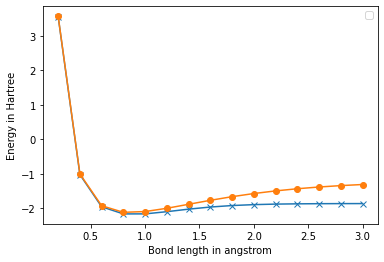

In [9]:
#Energy Plot Example
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.2
n_points = 15

# Set calculation parameters.
run_scf = 1 #Hartree-Fock
run_mp2 = 0 #2nd order Moller-Plesset (special case of R-S PT)
run_cisd = 0 # Configuration interaction with single and double excitations
run_ccsd = 0 #Coupled Cluster
run_fci = 1 #Full configuration interaction
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length)), ('H', (0., 0., 2*bond_length)), ('H', (0., 0., 3*bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run Psi4.
    molecule = run_pyscf(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)
    print("here!")
    print(molecule.two_body_integrals)
    # Print out some results of calculation.
    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
        bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
        molecule.nuclear_repulsion))
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()

In [3]:
#METHANE
methane_geometry = [('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]
print(methane_geometry)

basis = 'sto-3g'
multiplicity = 1 #2ns+1

# Set calculation parameters (to populate the molecular data class)
run_scf = True #Hartree-Fock
run_mp2 = True #2nd order Moller-Plesset (special case of R-S PT)
run_cisd = True # Configuration interaction with single and double excitations
run_ccsd = True #Coupled Cluster
run_fci = True #Full configuration interaction
verbose = True
tolerate_error = False

#delete_input = True
#delete_output = True

# Generate and populate instance of MolecularData.
methane_molecule = MolecularData(methane_geometry, basis, multiplicity, description="testing_methane", filename="methane")
if os.path.exists(methane_molecule.filename + '.hdf5'):
    methane_molecule.load()
else:
    methane_molecule = run_pyscf(methane_molecule, run_scf=run_scf, run_mp2=run_mp2, run_cisd=run_cisd, run_ccsd=run_ccsd, run_fci=run_fci, verbose=verbose)
    two_body_integrals = methane_molecule.two_body_integrals
    methane_molecule.save()


[('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]
Hartree-Fock energy for H4-C1_sto-3g_singlet_testing_methane (10 electrons) is -39.72658171185192.
MP2 energy for H4-C1_sto-3g_singlet_testing_methane (10 electrons) is -39.78337408827044.
CISD energy for H4-C1_sto-3g_singlet_testing_methane (10 electrons) is -39.80354728365674.
CCSD energy for H4-C1_sto-3g_singlet_testing_methane (10 electrons) is -39.80602194253342.


/Users/matt/opt/anaconda3/envs/compsim/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/matt/opt/anaconda3/envs/compsim/lib/python3.7/site-packages/pyscf/lib/misc.py:874: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


FCI energy for H4-C1_sto-3g_singlet_testing_methane (10 electrons) is -39.80625924915008.


In [4]:
# Set Hamiltonian parameters.
active_space_start = 1
active_space_stop = 6
# Get the Hamiltonian in an active space.
methane_molecular_hamiltonian = methane_molecule.get_molecular_hamiltonian(occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
methane_fermion_hamiltonian = get_fermion_operator(methane_molecular_hamiltonian)
methane_qubit_hamiltonian = jordan_wigner(methane_fermion_hamiltonian)
methane_hamiltonian_list = openfermion_matrix_list(methane_qubit_hamiltonian)
print(methane_hamiltonian_list.shape)
print(methane_hamiltonian_list)

(828, 1024, 1024)
[[[-35.14437815+0.j   0.        +0.j   0.        +0.j ...
     0.        +0.j   0.        +0.j   0.        +0.j]
  [  0.        +0.j -35.14437815+0.j   0.        +0.j ...
     0.        +0.j   0.        +0.j   0.        +0.j]
  [  0.        +0.j   0.        +0.j -35.14437815+0.j ...
     0.        +0.j   0.        +0.j   0.        +0.j]
  ...
  [  0.        +0.j   0.        +0.j   0.        +0.j ...
   -35.14437815+0.j   0.        +0.j   0.        +0.j]
  [  0.        +0.j   0.        +0.j   0.        +0.j ...
     0.        +0.j -35.14437815+0.j   0.        +0.j]
  [  0.        +0.j   0.        +0.j   0.        +0.j ...
     0.        +0.j   0.        +0.j -35.14437815+0.j]]

 [[  0.99146998+0.j   0.        +0.j   0.        +0.j ...
     0.        +0.j   0.        +0.j   0.        +0.j]
  [  0.        +0.j   0.99146998+0.j   0.        +0.j ...
     0.        +0.j   0.        +0.j   0.        +0.j]
  [  0.        +0.j   0.        +0.j   0.99146998+0.j ...
     0.     

In [5]:
#ETHANE
ethane_geometry = geometry_from_pubchem('ethane')

basis = 'sto-3g'
multiplicity = 1 #2ns+1

# Set Hamiltonian parameters.
active_space_start = 1
active_space_stop = 5

# Set calculation parameters (to populate the molecular data class)
run_scf = True #Hartree-Fock
run_mp2 = True #2nd order Moller-Plesset (special case of R-S PT)
run_cisd = True # Configuration interaction with single and double excitations
run_ccsd = True #Coupled Cluster
run_fci = False #Full configuration interaction
verbose = True
tolerate_error = False

#delete_input = True
#delete_output = True

# Generate and populate instance of MolecularData.
ethane_molecule = MolecularData(ethane_geometry, basis, multiplicity, description="testing_ethane", filename="ethane")
if os.path.exists(ethane_molecule.filename + '.hdf5'):
    ethane_molecule.load()
else:
    ethane_molecule = run_pyscf(ethane_molecule, run_scf=run_scf, run_mp2=run_mp2, run_cisd=run_cisd, run_ccsd=run_ccsd, run_fci=run_fci, verbose=verbose)
    two_body_integrals = ethane_molecule.two_body_integrals
    ethane_molecule.save()

# Get the Hamiltonian in an active space.
ethane_molecular_hamiltonian = ethane_molecule.get_molecular_hamiltonian(occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
ethane_fermion_hamiltonian = get_fermion_operator(ethane_molecular_hamiltonian)
ethane_qubit_hamiltonian = jordan_wigner(ethane_fermion_hamiltonian)
ethane_hamiltonian_list = openfermion_matrix_list(ethane_qubit_hamiltonian)
print(ethane_hamiltonian_list.shape)
#print(ethane_hamiltonian_list)

Hartree-Fock energy for H6-C2_sto-3g_singlet_testing_ethane (18 electrons) is -78.30530748040042.
MP2 energy for H6-C2_sto-3g_singlet_testing_ethane (18 electrons) is -78.41254329354142.
CISD energy for H6-C2_sto-3g_singlet_testing_ethane (18 electrons) is -78.44280988581217.
CCSD energy for H6-C2_sto-3g_singlet_testing_ethane (18 electrons) is -78.45139298077807.
(149, 256, 256)


In [ ]:
#ELECTRON RING
import os

from openfermion.chem import make_atomic_ring

from openfermionpyscf import run_pyscf


if __name__ == '__main__':

    # Set chemical parameters.
    basis = 'sto-3g'
    max_electrons = 10
    spacing = 0.7414

    # Select calculations.
    force_recompute = 1
    run_scf = 1
    run_mp2 = 1
    run_cisd = 1
    run_ccsd = 1
    run_fci = 1
    verbose = 1

    # Generate data.
    for n_electrons in range(2, max_electrons + 1):

        # Initialize.
        molecule = make_atomic_ring(n_electrons, spacing, basis)
        if os.path.exists(molecule.filename + '.hdf5'):
            molecule.load()

        # To run or not to run.
        if run_scf and not molecule.hf_energy:
            run_job = 1
        elif run_mp2 and not molecule.mp2_energy:
            run_job = 1
        elif run_cisd and not molecule.cisd_energy:
            run_job = 1
        elif run_ccsd and not molecule.ccsd_energy:
            run_job = 1
        elif run_fci and not molecule.fci_energy:
            run_job = 1
        else:
            run_job = force_recompute

        # Run.
        if run_job:
            molecule = run_pyscf(molecule,
                                 run_scf=run_scf,
                                 run_mp2=run_mp2,
                                 run_cisd=run_cisd,
                                 run_ccsd=run_ccsd,
                                 run_fci=run_fci,
                                 verbose=verbose)
            molecule.save()

Hartree-Fock energy for H2_sto-3g_singlet_ring_0.7414 (2 electrons) is -1.116684387085341.
MP2 energy for H2_sto-3g_singlet_ring_0.7414 (2 electrons) is -1.1298551535553099.
CISD energy for H2_sto-3g_singlet_ring_0.7414 (2 electrons) is -1.1372701746609029.
CCSD energy for H2_sto-3g_singlet_ring_0.7414 (2 electrons) is -1.1372703406409197.
FCI energy for H2_sto-3g_singlet_ring_0.7414 (2 electrons) is -1.1372701746609035.
Hartree-Fock energy for H3_sto-3g_doublet_ring_0.7414 (3 electrons) is -1.137610389314911.


/opt/anaconda3/envs/pyscf/lib/python3.7/site-packages/pyscf/dft/numint.py:33: UserWarning: XC functional libraries (libxc or XCfun) are not available.
  warnings.warn('XC functional libraries (libxc or XCfun) are not available.')


CISD energy for H3_sto-3g_doublet_ring_0.7414 (3 electrons) is -1.1632600875370358.
CCSD energy for H3_sto-3g_doublet_ring_0.7414 (3 electrons) is -1.1632600875369001.
FCI energy for H3_sto-3g_doublet_ring_0.7414 (3 electrons) is -1.163260087537024.
Hartree-Fock energy for H4_sto-3g_singlet_ring_0.7414 (4 electrons) is -1.5050490723964756.
MP2 energy for H4_sto-3g_singlet_ring_0.7414 (4 electrons) is -1.546079523095781.
CISD energy for H4_sto-3g_singlet_ring_0.7414 (4 electrons) is -1.6219202302572142.
CCSD energy for H4_sto-3g_singlet_ring_0.7414 (4 electrons) is -1.625426123529533.
FCI energy for H4_sto-3g_singlet_ring_0.7414 (4 electrons) is -1.4742181454453003.
Hartree-Fock energy for H5_sto-3g_doublet_ring_0.7414 (5 electrons) is -2.2113800225814595.
CISD energy for H5_sto-3g_doublet_ring_0.7414 (5 electrons) is -2.2530399793275477.
CCSD energy for H5_sto-3g_doublet_ring_0.7414 (5 electrons) is -2.253363774740828.
FCI energy for H5_sto-3g_doublet_ring_0.7414 (5 electrons) is -2.25

In [3]:
#HYDROGEN CHAINS
def hydrogen_chain_hamiltonian(chain_length, bond_length): 
    hydrogen_geometry = []
    for i in range(chain_length):
        hydrogen_geometry.append(('H', (bond_length * i, 0, 0)))

    print("Geometry in use:")
    print(hydrogen_geometry)
    basis = 'sto-3g'
    if chain_length % 2 == 0:
        multiplicity = 1 #2ns+1
    else:
        multiplicity = 2

    # Set Hamiltonian parameters.
    active_space_start = 0
    active_space_stop = chain_length 

    # Set calculation parameters (to populate the molecular data class)
    run_scf = True #Hartree-Fock
    run_mp2 = True #2nd order Moller-Plesset (special case of R-S PT)
    run_cisd = True # Configuration interaction with single and double excitations
    run_ccsd = True #Coupled Cluster
    run_fci = True #Full configuration interaction
    verbose = True

    # Generate and populate instance of MolecularData.
    hydrogen = MolecularData(hydrogen_geometry, basis, multiplicity, description="hydrogen_chain_" + str(chain_length) +"_"+str(bond_length), filename="hydrogen_" + str(chain_length) +"_"+str(bond_length))
    if os.path.exists(hydrogen.filename + '.hdf5'):
        hydrogen.load()
    else:
        hydrogen = run_pyscf(hydrogen, run_scf=run_scf, run_mp2=run_mp2, run_cisd=run_cisd, run_ccsd=run_ccsd, run_fci=run_fci, verbose=verbose)
        #two_body_integrals = hydrogen.two_body_integrals
        hydrogen.save()

    # Get the Hamiltonian in an active space.
    hydrogen_molecular_hamiltonian = hydrogen.get_molecular_hamiltonian(occupied_indices=range(active_space_start),
        active_indices=range(active_space_start, active_space_stop))

    # Map operator to fermions and qubits.
    hydrogen_fermion_hamiltonian = get_fermion_operator(hydrogen_molecular_hamiltonian)
    hydrogen_qubit_hamiltonian = jordan_wigner(hydrogen_fermion_hamiltonian)
    hydrogen_hamiltonian_list = openfermion_matrix_list(hydrogen_qubit_hamiltonian)
    print(hydrogen_hamiltonian_list.shape)
    #print(hydrogen_hamiltonian_list)
    return hydrogen_hamiltonian_list

In [5]:
# WARNING DO NOT USE GREATER THAN OR EQUAL TO 6
i = 2
h2 = hydrogen_chain_hamiltonian(i, 0.8)
print(len(h2))
print(type(h2))
print("dim:", h2[0].shape)
shape = h2[0].shape
as_a_list = [h2[ix,:,:] for ix in range(len(h2))]
as_a_list.append(shape)
print('as a list type', type(as_a_list))
print("as a list[0]:")
print(type(as_a_list[0]))
pickle_hamiltonian('/Users/matt/scratch/hamiltonians/h_chain_' + str(i) + '.pickle', h2, clobber=True)

Geometry in use:
[('H', (0.0, 0, 0)), ('H', (0.8, 0, 0))]
(15, 16, 16)
15
<class 'numpy.ndarray'>
dim: (16, 16)
as a list type <class 'list'>
as a list[0]:
<class 'numpy.ndarray'>
[pickle_hamiltonian] you thought, exception: [Errno 2] No such file or directory: '/Users/matt/scratch/hamiltonians/h_chain_2.pickle'


Geometry in use:
[('H', (0.0, 0, 0)), ('H', (0.8, 0, 0))]
Hartree-Fock energy for H2_sto-3g_singlet_hydrogen_chain_2_0.8 (2 electrons) is -1.1108503974765949.
MP2 energy for H2_sto-3g_singlet_hydrogen_chain_2_0.8 (2 electrons) is -1.125453533993143.
CISD energy for H2_sto-3g_singlet_hydrogen_chain_2_0.8 (2 electrons) is -1.1341476666770955.
CCSD energy for H2_sto-3g_singlet_hydrogen_chain_2_0.8 (2 electrons) is -1.1341478692541536.
FCI energy for H2_sto-3g_singlet_hydrogen_chain_2_0.8 (2 electrons) is -1.1341476666770949.
(15, 16, 16)
(15, 16, 16)


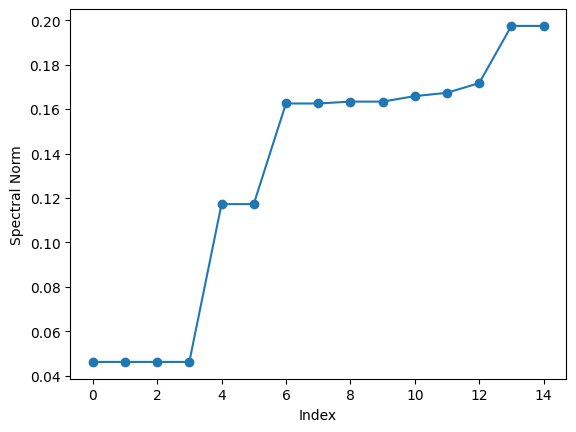

There are 0 terms with 0 spectral norm


[0.046156695889015324,
 0.046156695889015324,
 0.046156695889015324,
 0.046156695889015324,
 0.11720364720195847,
 0.11720364720195847,
 0.16251648748871653,
 0.16251648748871653,
 0.1633603430909738,
 0.1633603430909738,
 0.16583253721590402,
 0.16733398905695274,
 0.17169788392286725,
 0.19744293699755816,
 0.19744293699755816]

In [4]:
h2 = hydrogen_chain_hamiltonian(2, 0.8)
print(h2.shape)
ham_spec(h2)

In [7]:
print((np.geomspace(1,5,10)))

[1.         1.19581317 1.42996915 1.70997595 2.04481177 2.44521285
 2.92401774 3.49657893 4.18125515 5.        ]
